# Hierarchical Linear Regression (Radon Contamination dataset)

## Prepare Notebook

In [80]:
import arviz as az
from bambi import Model
from bambi import Prior
import numpy as np
import pandas as pd
import pymc3 as pm

import matplotlib.pyplot as plt
import seaborn as sns
az.style.use("arviz-darkgrid")
np.random.default_rng(8924)

%load_ext autoreload
%autoreload 2
# %config InlineBackend.figure_format = "svg"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read Data

In [81]:
path = "https://raw.githubusercontent.com/pymc-devs/pymc-examples/main/examples/data/srrs2.dat"

srrs2 = pd.read_csv(path, sep=",",  on_bad_lines='skip')

## Preprocess Data

In [82]:
# Filter data for state `MN`
srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state == "MN"].copy()

# Compute flips
srrs_mn["fips"] = srrs_mn.stfips * 1000 + srrs_mn.cntyfips
cty = pd.read_csv(pm.get_data("cty.dat"))
cty_mn = cty[cty.st == "MN"].copy()
cty_mn["fips"] = 1000 * cty_mn.stfips + cty_mn.ctfips

# Merge data
srrs_mn = srrs_mn.merge(cty_mn[["fips", "Uppm"]], on="fips")
srrs_mn = srrs_mn.drop_duplicates(subset="idnum")
u = np.log(srrs_mn.Uppm).unique()

n = len(srrs_mn)

# Get lookup table for counties
srrs_mn.county = srrs_mn.county.map(str.strip)
mn_counties = srrs_mn.county.unique()
counties = len(mn_counties)
county_lookup = dict(zip(mn_counties, range(counties)))

# local copies of variables
county = srrs_mn["county_code"] = srrs_mn.county.replace(county_lookup).values
radon = srrs_mn.activity
srrs_mn["log_radon"] = log_radon = np.log(radon + 0.1).values
floor = srrs_mn.floor.values

In [83]:
srrs_mn.columns

Index(['idnum', 'state', 'state2', 'stfips', 'zip', 'region', 'typebldg',
       'floor', 'room', 'basement', 'windoor', 'rep', 'stratum', 'wave',
       'starttm', 'stoptm', 'startdt', 'stopdt', 'activity', 'pcterr', 'adjwt',
       'dupflag', 'zipflag', 'cntyfips', 'county', 'fips', 'Uppm',
       'county_code', 'log_radon'],
      dtype='object')

## Models: Conventional Approaches

### Complete Pooling

Treat all counties the same, and estimate a single radon level.

In [84]:
srrs_mn.sort_values(by="floor", inplace=True)

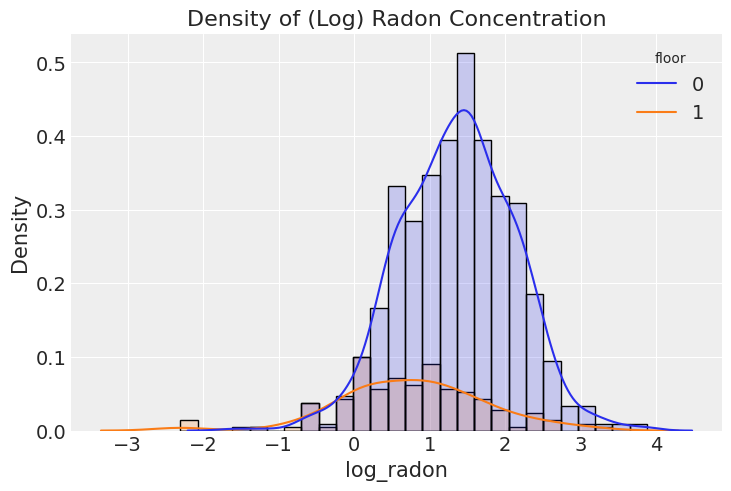

In [85]:
fig, ax = plt.subplots()
sns.histplot(x="log_radon", hue="floor", alpha=0.2, stat="density", data=srrs_mn, ax=ax)
sns.kdeplot(x="log_radon", hue="floor", data=srrs_mn, ax=ax)
ax.set(title="Density of (Log) Radon Concentration", ylabel="Density");

In [86]:
pooled_priors = {
    "Intercept": Prior(name="Normal", mu=0.0, sigma=10.0),
    "floor": Prior(name="Normal", mu=0.0, sigma=10.0),
    "sigma": Prior(name="Exponential", lam=1.0),
}

pooled_model = Model(
    formula="log_radon ~ floor",
    data=srrs_mn,
    priors=pooled_priors,
    family="gaussian",
    link="identity",
)

pooled_model

Formula: log_radon ~ floor
Family name: Gaussian
Link: identity
Observations: 919
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0.0, sigma: 10.0)
    floor ~ Normal(mu: 0.0, sigma: 10.0)

  Auxiliary parameters
    sigma ~ Exponential(lam: 1.0)

In [87]:
pooled_results = pooled_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_radon_sigma, floor, Intercept]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


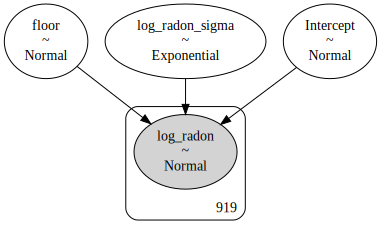

In [88]:
pm.model_to_graphviz(pooled_model.backend.model)

In [89]:
az.summary(data=pooled_results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.362,0.028,1.308,1.411,0.000,0.000,5707.0,3179.0,1.0
floor,-0.587,0.071,-0.714,-0.451,0.001,0.001,5253.0,2911.0,1.0
log_radon_sigma,0.791,0.018,0.758,0.825,0.000,0.000,5398.0,3075.0,1.0


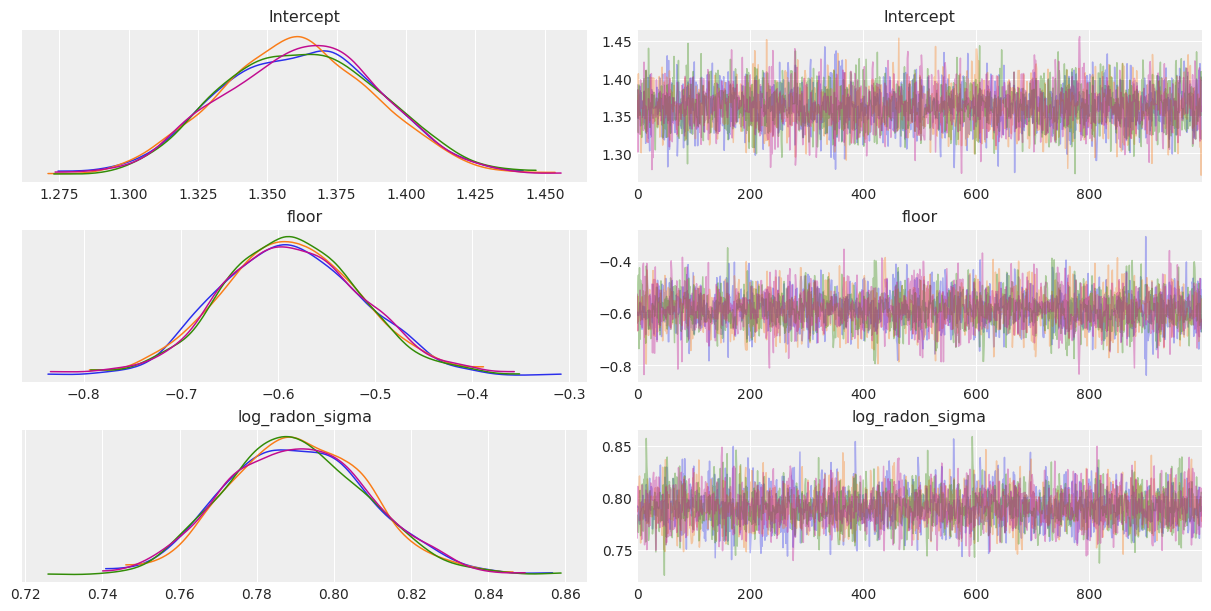

In [90]:
az.plot_trace(data=pooled_results, compact=False);

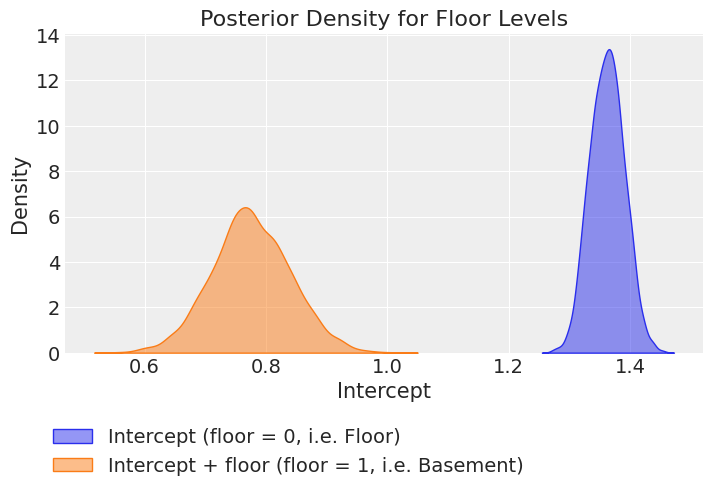

In [91]:
pooled_results_posterior_stacked = pooled_results.posterior.stack(sample=('chain', 'draw'))

fig, ax = plt.subplots()
sns.kdeplot(
    x=pooled_results_posterior_stacked ["Intercept"],
    fill=True,
    alpha=0.5,
    label="Intercept (floor = 0, i.e. Floor)",
    ax=ax
);
sns.kdeplot(
    x=(pooled_results_posterior_stacked ["Intercept"]
        + pooled_results_posterior_stacked ["floor"]),
    fill=True,
    alpha=0.5,
    label="Intercept + floor (floor = 1, i.e. Basement)",
    ax=ax
)
ax.legend(loc="upper left")
ax.legend(loc='upper center', bbox_to_anchor=(0.35, -0.18))
ax.set(title="Posterior Density for Floor Levels", ylabel="Density");

### No Pooling

Model radon in each county independently.



In [92]:
unpooled_priors = {
    "county": Prior(name="Normal", mu=0.0, sigma=10.0),
    "county:floor": Prior(name="Normal", mu=0.0, sigma=10.0),
    "sigma": Prior(name="Exponential", lam=1.0),
}

unpooled_model = Model(
    formula="log_radon ~ 0 + county + county:floor",
    data=srrs_mn,
    priors=unpooled_priors,
    family="gaussian",
    link="identity",
    auto_scale=False,
 )

unpooled_model

Formula: log_radon ~ 0 + county + county:floor
Family name: Gaussian
Link: identity
Observations: 919
Priors:
  Common-level effects
    county ~ Normal(mu: 0.0, sigma: 10.0)
    county:floor ~ Normal(mu: 0.0, sigma: 10.0)

  Auxiliary parameters
    sigma ~ Exponential(lam: 1.0)

In [93]:
unpooled_results = unpooled_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_radon_sigma, county:floor, county]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.


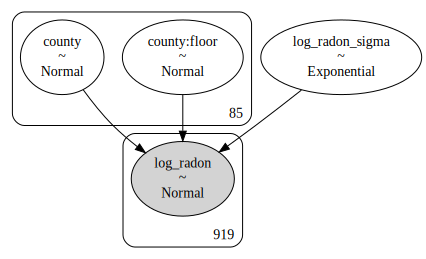

In [94]:
pm.model_to_graphviz(unpooled_model.backend.model)

In [95]:
az.summary(data=unpooled_results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
county[AITKIN],0.671,0.417,-0.077,1.486,0.005,0.004,6966.0,3202.0,1.0
county[ANOKA],0.951,0.102,0.765,1.140,0.001,0.001,9359.0,3206.0,1.0
county[BECKER],1.474,0.711,0.224,2.906,0.009,0.007,6544.0,2833.0,1.0
county[BELTRAMI],1.714,0.401,1.009,2.513,0.005,0.003,7746.0,3238.0,1.0
county[BENTON],1.342,0.415,0.518,2.089,0.005,0.004,7419.0,3265.0,1.0
...,...,...,...,...,...,...,...,...,...
county:floor[WILKIN],-0.085,9.644,-17.590,18.002,0.106,0.192,8323.0,2712.0,1.0
county:floor[WINONA],-1.986,0.462,-2.869,-1.146,0.005,0.004,7888.0,3327.0,1.0
county:floor[WRIGHT],-0.801,0.754,-2.241,0.582,0.008,0.009,8074.0,3050.0,1.0
county:floor[YELLOW MEDICINE],0.042,10.335,-18.966,19.261,0.110,0.193,8828.0,2045.0,1.0


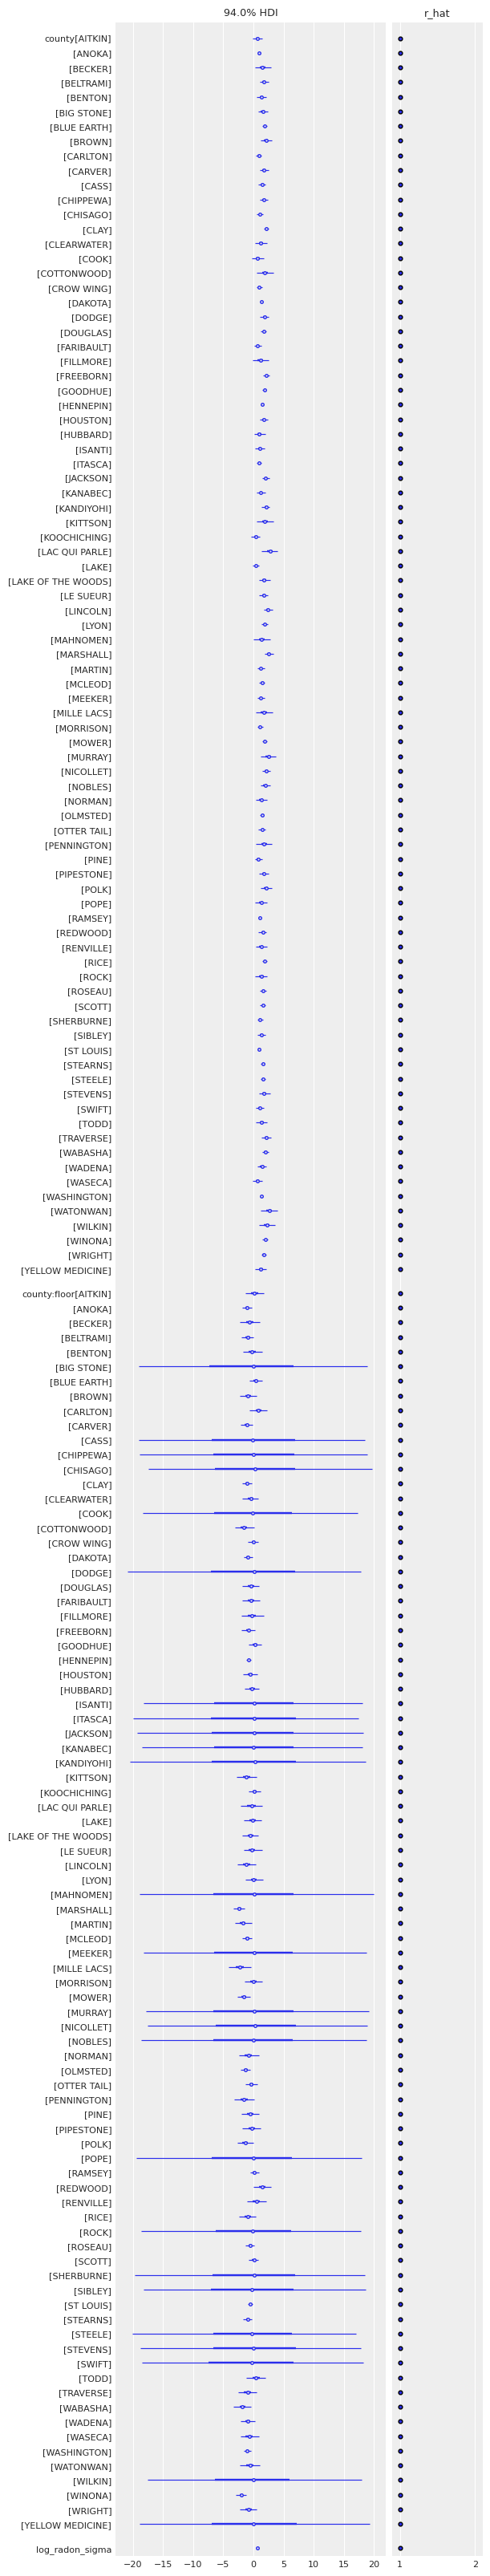

In [96]:
az.plot_forest(data=unpooled_results, figsize=(6, 32), r_hat=True, combined=True, textsize=8);

## Multilevel and Hierarchical Models

### Partial Pooling Model

In [104]:
partial_pooling_priors = {
    "1|county": Prior(name="Normal", mu=0.0, sigma=10.0),
    "sigma": Prior(name="Exponential", lam=1.0),
}

partial_pooling_model = Model(
    formula="log_radon ~ 0 + (0 + 1|county)",
    data=srrs_mn,
    priors=partial_pooling_priors,
    family="gaussian",
    link="identity",
    auto_scale=False,
 )

partial_pooling_model

Formula: log_radon ~ 0 + (0 + 1|county)
Family name: Gaussian
Link: identity
Observations: 919
Priors:


  Group-level effects
    1|county ~ Normal(mu: 0.0, sigma: 10.0)

  Auxiliary parameters
    sigma ~ Exponential(lam: 1.0)

In [105]:
partial_pooling_results = partial_pooling_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_radon_sigma, 1|county]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.


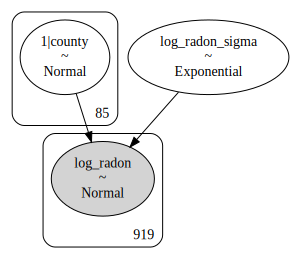

In [106]:
pm.model_to_graphviz(partial_pooling_model.backend.model)

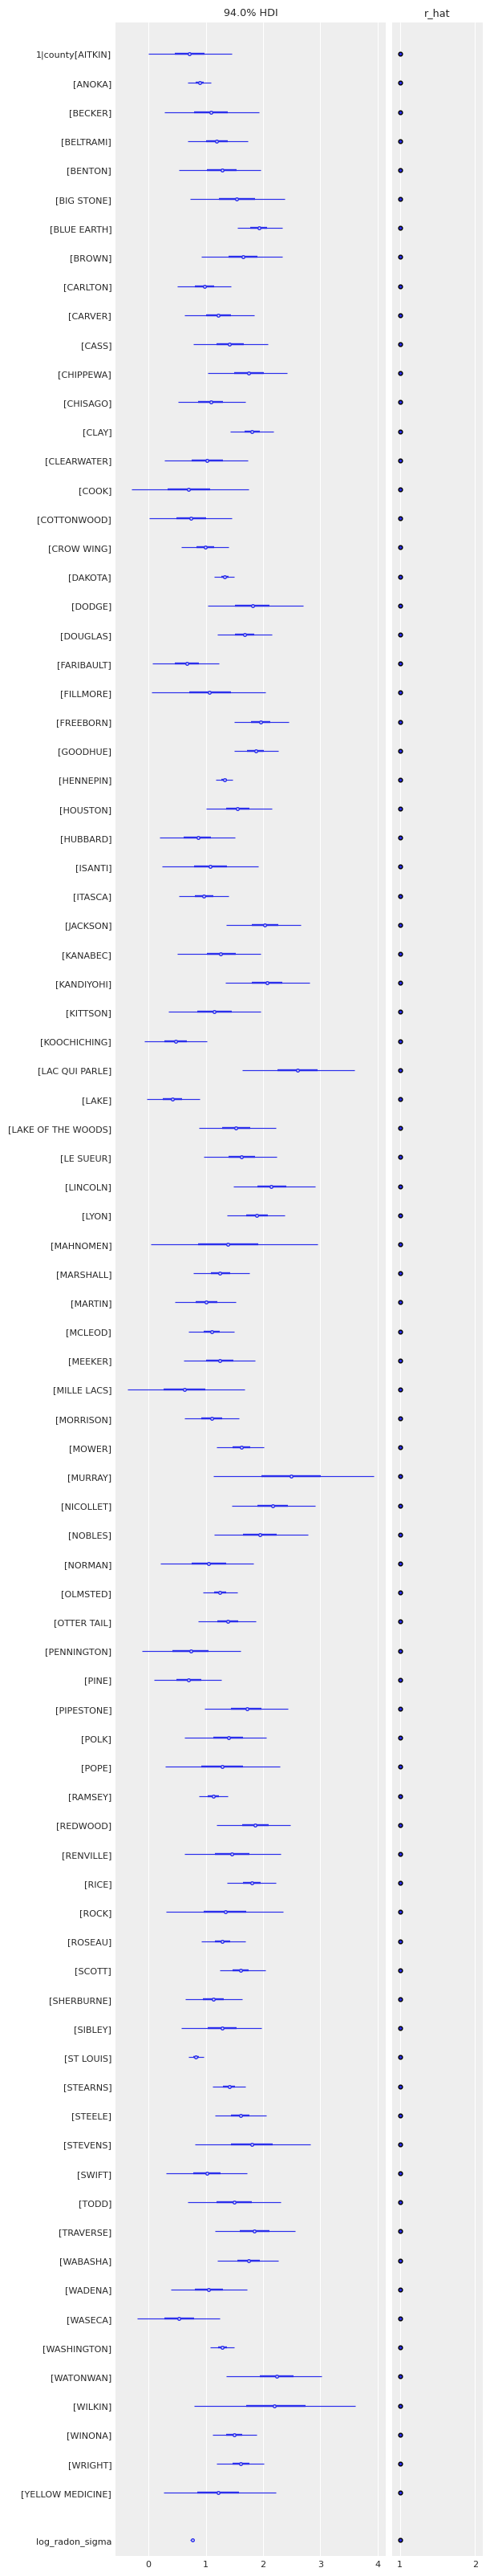

In [107]:
az.plot_forest(data=partial_pooling_results, figsize=(6, 32), r_hat=True, combined=True, textsize=8);

### Varying Intercept Model

In [134]:
varying_intercept_priors = {
    "floor": Prior(name="Normal", mu=0.0, sigma=10.0),
    "1|county": Prior(name="Normal", mu=0.0, sigma=10.0),
    "sigma": Prior(name="Exponential", lam=1.0),
}

varying_intercept_model = Model(
    formula="log_radon ~ 0 + (1|county) + floor", # ! How to do complete one-hot-encoding for county?
    data=srrs_mn,
    priors=varying_intercept_priors,
    family="gaussian",
    link="identity",
 )

varying_intercept_model

Formula: log_radon ~ 0 + (1|county) + floor
Family name: Gaussian
Link: identity
Observations: 919
Priors:
  Common-level effects
    floor ~ Normal(mu: 0.0, sigma: 10.0)

  Group-level effects
    1|county ~ Normal(mu: 0.0, sigma: 10.0)

  Auxiliary parameters
    sigma ~ Exponential(lam: 1.0)

In [135]:
varying_intercept_results = varying_intercept_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_radon_sigma, 1|county, floor]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


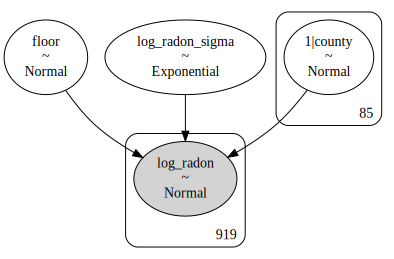

In [136]:
pm.model_to_graphviz(varying_intercept_model.backend.model)

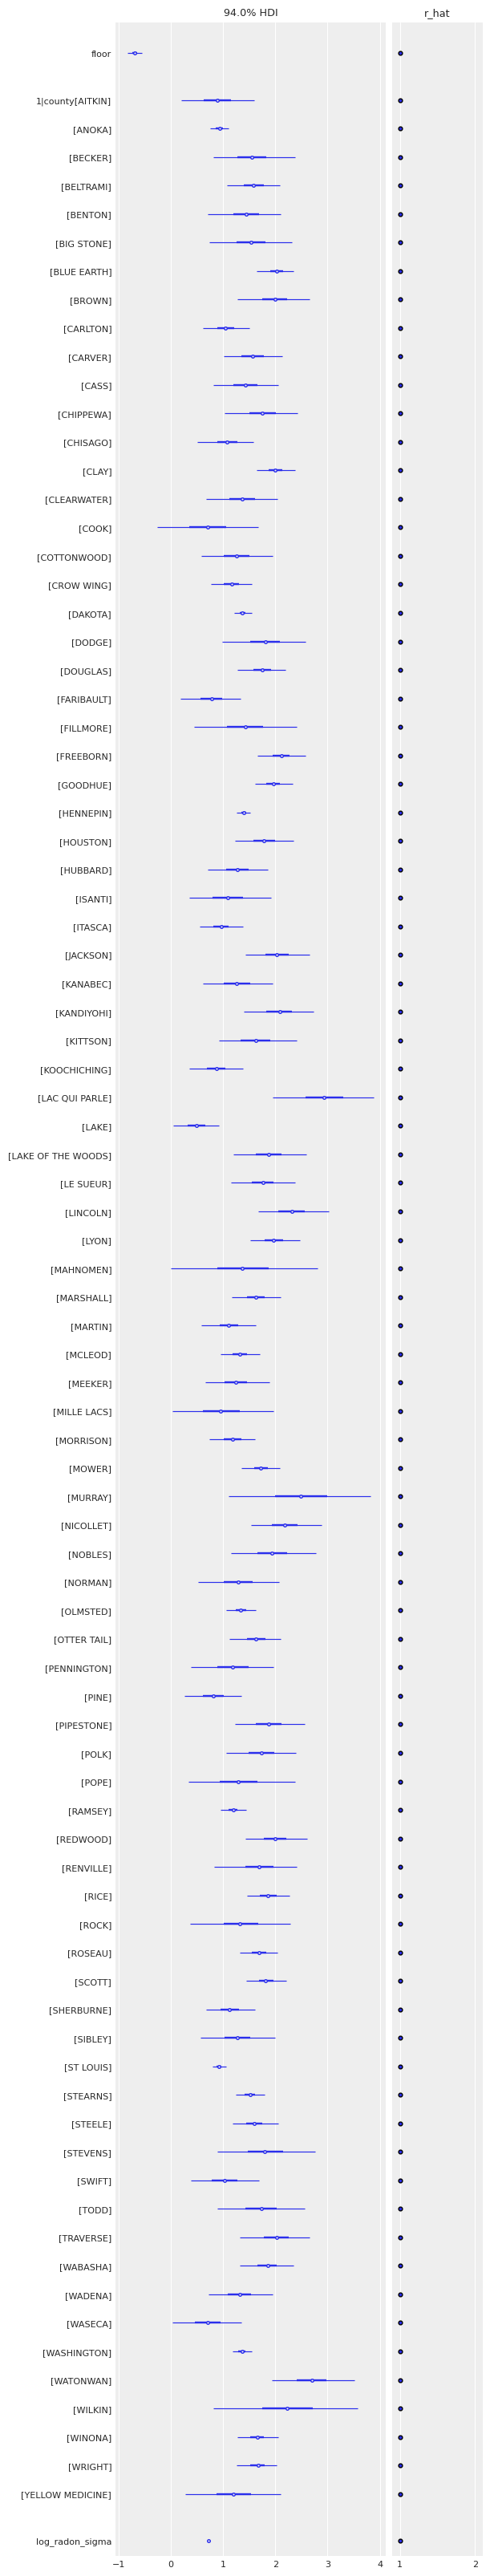

In [137]:
az.plot_forest(data=varying_intercept_results, figsize=(6, 32), r_hat=True, combined=True, textsize=8);

### Varying Intercept and Slope Model

In [139]:
varying_intercept_slope_priors = {
    "floor|county": Prior(name="Normal", mu=0.0, sigma=10.0),
    "sigma": Prior(name="Exponential", lam=1.0),
}

varying_intercept_slope_model = Model(
    formula="log_radon ~ 0 + (floor|county)", # ! How to do complete one-hot-encoding for county?
    data=srrs_mn,
    priors=varying_intercept_slope_priors,
    family="gaussian",
    link="identity",
 )

varying_intercept_slope_model

Formula: log_radon ~ 0 + (floor|county)
Family name: Gaussian
Link: identity
Observations: 919
Priors:


  Group-level effects
    1|county ~ Normal(mu: 0, sigma: HalfNormal(sigma: 2.0473))
    floor|county ~ Normal(mu: 0.0, sigma: 10.0)

  Auxiliary parameters
    sigma ~ Exponential(lam: 1.0)

In [140]:
varying_intercept_slope_results = varying_intercept_slope_model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_radon_sigma, floor|county, 1|county_offset, 1|county_sigma]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 44 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


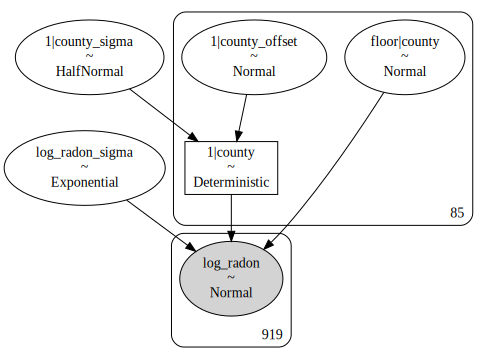

In [141]:
pm.model_to_graphviz(varying_intercept_slope_model.backend.model)

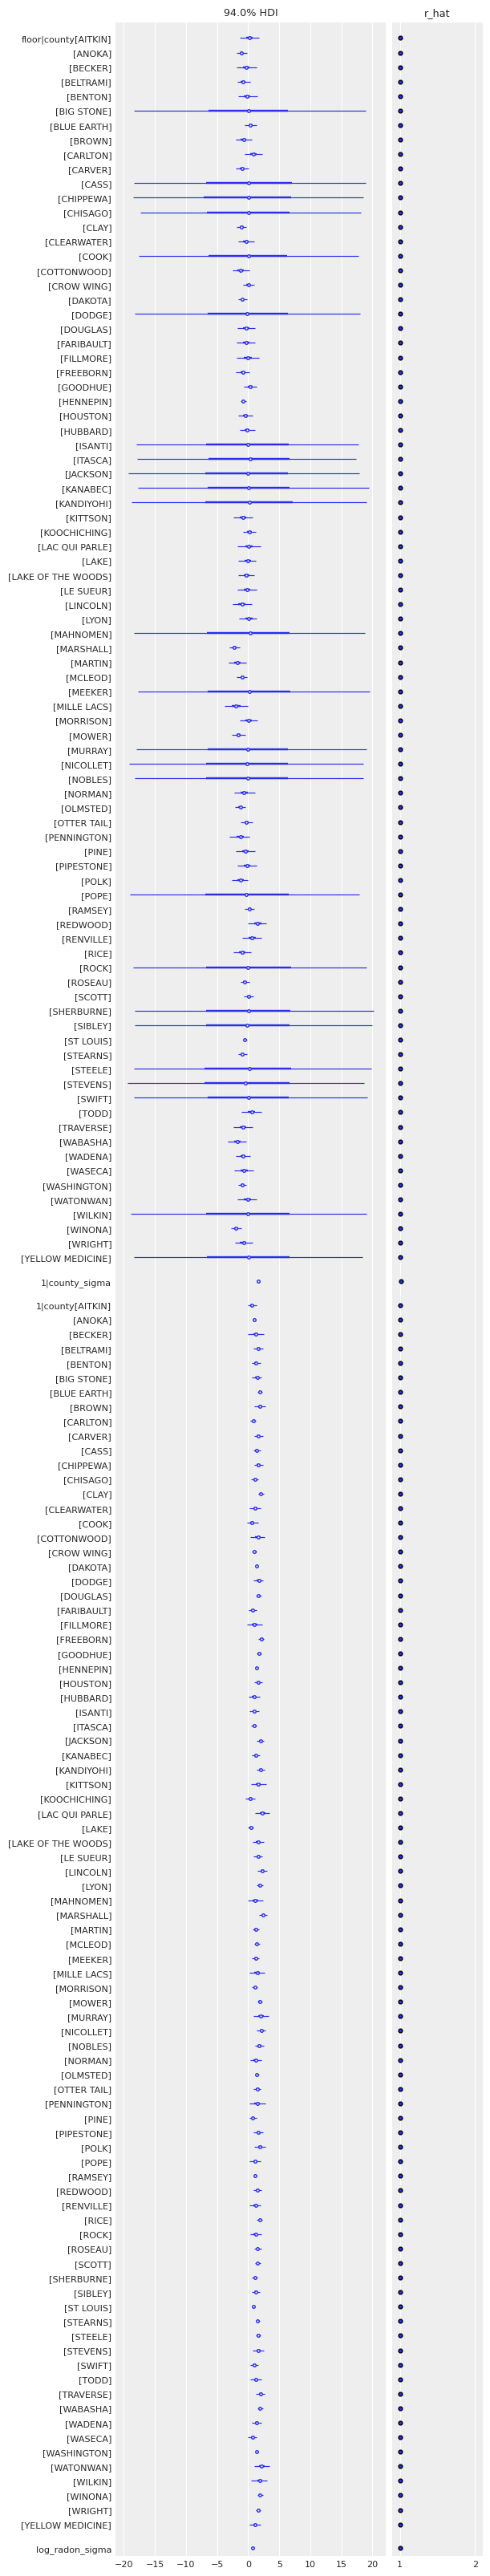

In [143]:
az.plot_forest(data=varying_intercept_slope_results, figsize=(6, 32), r_hat=True, combined=True, textsize=8);